***
# Equity Market Historical Underperformance In Q3: Statistically Significant?
***

**Research overview**

This article is about running an exhaustive analysis and testing of the Q3 underperformance phenomena described by CNBC with the use of Python. We will carefully ascertain its statistical significance to evaluate if investors can expect it to repeat in the future.

Seasonal anomalies remain a topic of ongoing discussion among academics and practitioners in finance. For equities, some believe in a January effect, turn-of-the-month effect, weekend effect, holiday effect, and the adage “Sell in May and go away”. These maxims frequently seem to be founded upon anecdotal evidence, but a prudent investor should rely on something more statistically rigorous.

We will highlight potential pitfalls to avoid when conducting statistical analysis (multiple comparison bias, p-hacking) and demonstrate how a seemingly significant result can become non-significant.

<img src="cnbc_quarters.jpeg">

**Notebook navigation**

* Import Price Data
* Wrangle with Pandas
* Hypothesis testing
* Simulation
* p-Values
* p-Hacking and Data Dredging
* Conclusion

***


### Import Price Data

**Fetch S&P 500 historical data from Yahoo Finance**

We will be using daily historical data for the S&P 500 from Yahoo Finance to conduct our analysis. Let's see how easily, with a few lines of code, we can import the data into our Python notebook:

In [18]:
# import Python libraries we will use in our research
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
from datetime import date
import matplotlib.pyplot as plt

# set the end date:
end = "2020-07-01"

# Yahoo's first date for S&P 500
start = "1928-01-01"

# S&P 500 symbol on Yahoo Finance
sp500_symbol = "^GSPC"

# download S&P 500 historical prices from Yahoo Finance
data = yf.download(sp500_symbol, start=start, end=end)

# show data's last five rows
data.tail()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-24,3114.40,3115.01,3032.13,3050.33,3050.33,5587200000
2020-06-25,3046.60,3086.25,3024.01,3083.76,3083.76,4815420000
2020-06-26,3073.20,3073.73,3004.63,3009.05,3009.05,8098120000
2020-06-29,3018.59,3053.89,2999.74,3053.24,3053.24,4462770000
2020-06-30,3050.20,3111.51,3047.83,3100.29,3100.29,4696280000


### Wrangle with Pandas

**Prepare the data to exhibit the phenomena we are investigating**

To answer the question: *Is the historical average underperformance of Q3 returns significant and therefore likely to continue?*, we need to transform the data into the correct format.

Let's calculate average quarterly returns and crosscheck our findings with CNBC data.

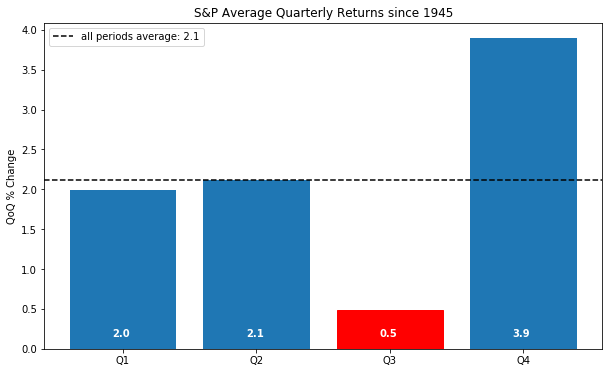

In [19]:
# we will only use closing prices so we can drop other columns
data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

# to replicate CNBC research select 1945 as the research starting date
data_daily = data.loc["1945-01-01":]

# resample data to the quarterly timeframe
data_quarterly = data_daily.resample("Q").last()

# calculate QoQ percentage change
data_quarterly = data_quarterly.pct_change().dropna()
data_quarterly.rename(columns={"Close": "returns"}, inplace=True)

# calculate the average quarterly performance:
data_quarterly_mu = data_quarterly.groupby(data_quarterly.index.quarter).mean()*100

# resize charts:
plt.rcParams['figure.figsize']=[10,6]

# Plot the data into a bar chart:
bar_plot = plt.bar(x=data_quarterly_mu.index, height=data_quarterly_mu.returns)
bar_plot[2].set_color('r')
for i, v in enumerate(round(data_quarterly_mu.returns,1)):
    plt.text(i+0.92,0.15, str(v), color='white', fontweight='bold')
plt.axhline(data_quarterly_mu.returns.mean(),ls='--',color='k',label='all periods average: '+str(round(data_quarterly_mu.returns.mean(),1)))
plt.title("S&P Average Quarterly Returns since 1945")
plt.ylabel("QoQ % Change")
plt.xticks([1,2,3,4], ['Q1', 'Q2', 'Q3', 'Q4'])
plt.legend()
plt.savefig('sp500_aqr.png')
plt.show()


*Looks close enough to CNBC, slight discrepancies may come from a different data source and/or rounding.*

### Hypothesis Testing

**What’s the question?**

One of the core concepts in statistics and data science is <a href="https://www.quantopian.com/lectures/hypothesis-testing"> hypothesis testing </a> and something called The Null Hypothesis.

It is also one of the most remarkably intimidating and misunderstood. The basis for this fear arises from the way it is taught in Stats 101, where you get bombarded with formulas and terminologies such as:

*t-test, Welch’s t-test, degrees of freedom, t-score, critical value, t statistic, statistical power, etc....*

This is where the usefulness of simulation with Python comes to light. You see, classical statistical techniques were developed at a time when we had very little computing power. They were merely closed-form analytical solutions to calculate p-values. But with the added complication of needing to figure out the appropriate formula for the given situation. And that makes them particularly difficult to use, because of their restrictive and sometimes opaque assumptions.

But before seeing how simulation can assist us, let's remind ourselves what hypothesis testing is:

It is the process of testing  *whether an observed effect (E) in our data is real or if it could happen simply by chance*. And to perform this test we do the following:

* Choose an appropriate *test statistic*: this is simply a number that measures the observed effect (E). We will use the Average Quarterly Return Deviations from the mean (AQRD).

* Construct the Null Hypothesis: It is where we create a version of the data where the observed effect (ie: the quarterly seasonality of the data) is not present. To do so, we will shuffle the daily returns repeatedly (permutation) to remove any seasonality from our data. We call the Null Hypothesis H0.

* Compute a p-value: At that point, we are going to compare H0 to the alternate hypothesis, HA, which is the model where the effect is 'real' (our original S&P 500 data). Ideally, we should compute the probability of observing E under both hypotheses; that is P (E | H0) and P (E | HA). But formulating HA is not always easy, so in conventional hypothesis testing, we just compute the probability of witnessing E under the Null Hypothesis P (E | H0) which is the p-value.

The most critical part of hypothesis testing is being clear what question we are trying to answer.

To begin with, let's start by asking:

***“Could the extreme deviation from the mean in Q3 happen by chance?”***

### Simulation

We now need to build our Null Hypothesis Model: A dataset with no effect (E) present, in other words with no seasonality.

There are many options at our disposal like parametric models, direct simulation, etc.

Alternatively, our analysis will implement a simulation by permutation using Numpy. We will repeatedly generate random samples of daily returns by shuffling the actual daily returns of the S&P 500 data. We then use these randomly shuffled returns to create price series that are going to serve us compute AQRDs. This has the desired effect of causing the observed phenomena to be equally likely for all quarters, which is exactly what our Null Hypothesis Model calls for.

The beauty of simulation is that we can explicitly model our assumptions through code. In contrast, classical techniques can seem like ‘black-box’ when it comes to their assumptions.

Let's now generate 1'000 samples for our research:

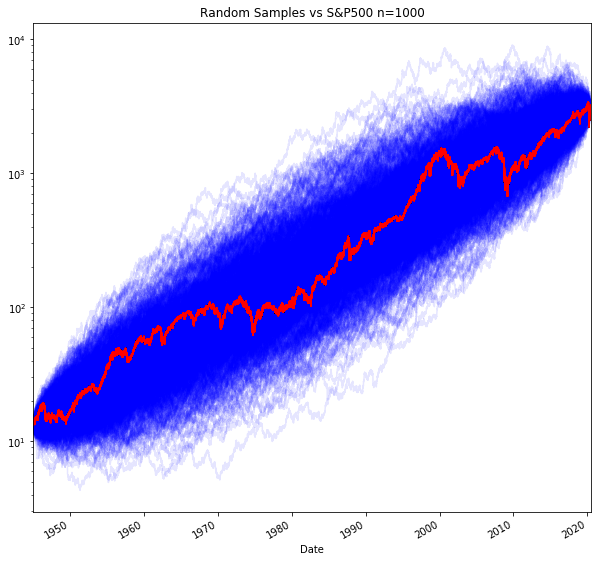

In [27]:
# set the random number seed so that results can be replicated
np.random.seed(1)

# set an empty container:
all_aqr = pd.DataFrame()

# set another empty container for use later in our p-hacking section:
lowest_quarters = []

# set the number of permutation samples we want to generate
n = 1000

# calculate actual daily_returns of the s&p 500
actual_rets = data_daily.Close.pct_change().dropna()

# set the number of observations
n_obs = actual_rets.count()

# generate our random samples using a for loop
for i in range(n):

    # create sample by permutation of actual returns
    sample_rets = np.random.permutation(actual_rets)

    # convert sample_rets to pd.series
    sample_rets = pd.Series(sample_rets, index=actual_rets.index)

    # select s&p 500 start price
    start = data_daily.Close.first('D')

    # add 1 to sample_rets and append to start
    sample_rets = sample_rets.add(1)
    sample_prices = start.append(sample_rets)

    # calculate the cumulative product
    sample_prices = sample_prices.cumprod()
    
    # resample sample_price to quarterly timeframe
    sample_prices_q = sample_prices.resample("Q").last()
    
    # calculate QoQ returns
    sample_rets_q = sample_prices_q.pct_change().dropna()

    # calculate the average quarterly returns
    aqr = sample_rets_q.groupby(sample_rets_q.index.quarter).mean() * 100
    
    # add our sample to the dataframe container
    all_aqr = pd.concat([all_aqr, aqr], axis=1)

    # also record the lowest AQR in each sample -for use in p-hacking section-
    min_quarter = min(aqr)
    lowest_quarters.append(min_quarter)
    
    # plot the generated samples vs s&p 500:
    sample_prices.plot(logy=True, color='blue', ls='-', alpha=0.1, title='Random Samples vs S&P500 n=1000')
    data_daily.Close.plot(color='r')

### P-Values

Statisticians ordinarily use “p-values” to analyze phenomena and compare hypotheses. A p-value quantifies the probability of observing a result at least as extreme as the one observed in the case of the Null Hypothesis being true. For a result to be interesting, it should have a low p-value, but the exact significance level (α) choice is a subjective decision.

Our study will use the conventional threshold of 0.05 for α and say that if our result is below α, the effect (E) is significant and unlikely to have occurred by chance, as there is less than a 5% probability the Null Hypothesis is correct.

After defining the hypothesis to test, we have generated 1'000 random samples by permuting daily returns from the S&P 500 historical data.

We now need to perform our hypothesis test to assess the probability of observing a result as significant as Q3 given that H0 (no seasonality) is true.

Let's answer our first question:

***“Could the underperformance of Q3 happen by chance?”***

To achieve this, we compare the S&P 500 Q3 AQRD to all our 4'000 randomly generated AQRDs (4 * 1'000). We check how many quarters underperformed at least as extremely as our phenomena.

In [28]:
# create a list of all AQRs
all_quarters_aqr = all_aqr.values.flatten()

# calculate AQR mean
all_quarters_aqr_mu = np.mean(all_quarters_aqr)

# calculate all AQRDs
all_aqrd = abs(all_quarters_aqr - all_quarters_aqr_mu)

# set Q3 AQRD to a variable
q3_aqrd = abs(data_quarterly_mu.returns.min() - all_quarters_aqr_mu)

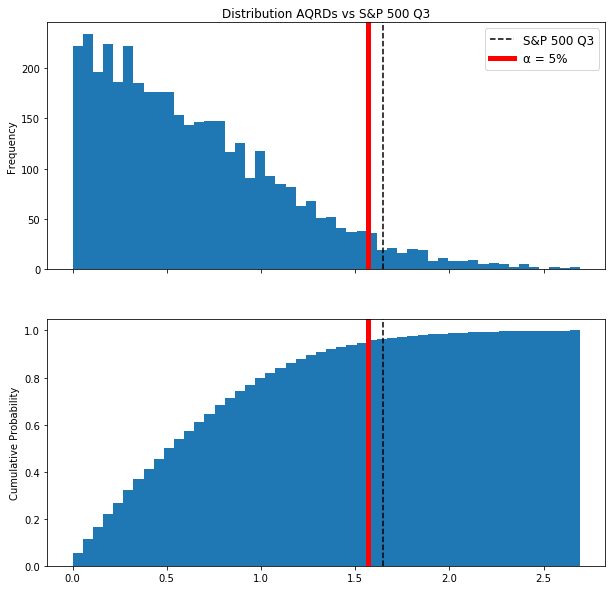

In [29]:
# set alpha
alpha = np.quantile(all_aqrd, .95)

# resize charts:
plt.rcParams['figure.figsize']=[10,10]

# create subplots
fig, (ax1, ax2) = plt.subplots(2)

# Plot Probability Density Function of AQRD
ax1.hist(all_aqrd, bins=50)
ax1.axvline(q3_aqrd, ls='--', color='k', label="S&P 500 Q3")
ax1.axvline(alpha,color='r',ls='-', label="α = 5%", lw=5)
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution AQRDs vs S&P 500 Q3")
# Plot Cumulative distribution function of AQRD
ax2.hist(all_aqrd, density=1, bins=50, cumulative=True)
ax2.axvline(q3_aqrd, ls='--', color='k', label="S&P 500 Q3")
ax2.axvline(alpha, color='r',ls='-', lw=5, label="α = 5%")
ax2.set_ylabel("Cumulative Probability")

# configure x-axes:
for ax in fig.get_axes():
    ax.label_outer()

# plot charts and legend
ax1.legend(fontsize=12)
plt.show()

In [30]:
def p_value_calc(samples, data_point):
    """Calculate the p-value from a population and a data point"""    
    
    # Define a counter and set it to 0
    count = 0
    
    # Count the number of samples greater or equal to the data point:
    for sample in samples:
        if sample >= data_point:
            count += 1
            
    # return p-value
    pval = count/len(samples)
    print ('p-value =', pval)

In [31]:
# Calculate p-value with our function:

p_value_calc(all_aqrd, q3_aqrd)        

p-value = 0.04


This gives a p-value of 0.04175 (≤ 0.05) that reject the Null Hypothesis H0 and argue that Q3 underperformance is significant as only 4.2% have a deviation from the mean as large as S&P 500 Q3. It is close to our somewhat arbitrary 5% cut off, but significant none the less.

That's it we just rejected the Null Hypothesis!

That's it? Not so fast!...

### P-Hacking and Data Dredging

Data dredging is *"the misuse of data analysis to find patterns in data that can be presented as statistically significant, thus dramatically increasing and understating the risk of false positives. This is done by performing many statistical tests on the data and only reporting those that come back with significant results."*- Wikipedia

* Second let's talk about <a href="https://www.quantopian.com/lectures/p-hacking-and-multiple-comparisons-bias"> multiple comparison bias</a>. Effectively it is when we expand our testing universe and increase the likelihood to get false positives. It is a problem because we can abuse this phenomenon to deliberately or accidentally pick the parameters of our model that give us a desired p-value. And this is the definition of p-hacking!

To demonstrate the effect of p-hacking and how to account for multiplicity, we need to grasp the subtle but critical difference between the following 2 questions:

***“What is the probability that any quarter would appear as extreme as Q3 by chance?”***

***“What is the probability that the worst quarter in each sample would appear as extreme as Q3 by chance?”***


The following code is all we need to compute the p-value to answer the 2nd question. To avoid multiplicity, instead of comparing our result to the distribution made with all 4'000 AQRDs, we only consider the lowest quarter in each of our 1'000 samples:

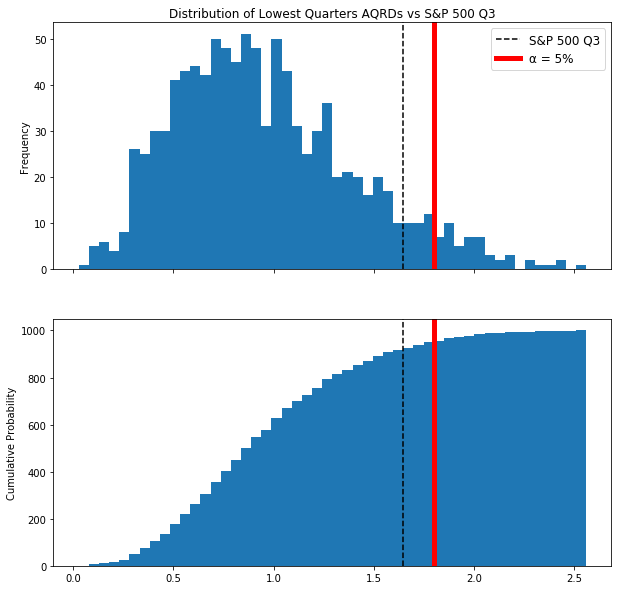

In [32]:
# calculate lowest quarter AQRDs
lowest_aqrd = abs(lowest_quarters - all_quarters_aqr_mu)

# set alpha
lowest_quarters_95 = np.quantile(lowest_aqrd, .95)

# create subplots
fig, (ax1, ax2) = plt.subplots(2)

# Plot Probability Density Function of quarterly returns
ax1.hist(lowest_aqrd, bins=50)
ax1.axvline(q3_aqrd,ls='--',color='k', label="S&P 500 Q3")
ax1.axvline(lowest_quarters_95,color='r',ls='-', lw=5, label="α = 5%")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution of Lowest Quarters AQRDs vs S&P 500 Q3")
# Plot Probability Density Function of quarterly returns
ax2.hist(lowest_aqrd, bins=50, cumulative=True)
ax2.axvline(q3_aqrd,ls='--',color='k', label="S&P 500 Q3")
ax2.axvline(lowest_quarters_95,color='r',ls='-', lw=5, label="α = 5%")
ax2.set_ylabel("Cumulative Probability")

for ax in fig.get_axes():
    ax.label_outer()
    
ax1.legend(fontsize=12)
plt.show()

In [33]:
# Calculate p-value with our function:

p_value_calc(lowest_aqrd, q3_aqrd)

p-value = 0.083


This gives a p-value of 9.3%, very much not significant!

We see that incorporating multiplicity makes α more conservative. To be considered a significant result, an absolute deviation would need to be at least 1.8%. This makes Q3’s no longer significant, with a 9.3% chance of observing a more extreme value of average quarterly returns if the Null Hypothesis is true.

## Conclusion

At first sight, Q3 appears to have extremely low returns, but in our simple test, we failed to observe sufficient evidence this underperformance is significant. We can quantify the probability of seeing results as extreme as ours in data with no seasonality, and it stands at 9.3%.

Had we not incorporated multiplicity into our analysis, then this probability would look far more interesting, at 4.2%. This straightforward seasonality example highlights the importance of using rigorous statistics in the world of investment management.

Finally, can we say the S&P as no seasonality?

Unfortunately, we cannot answer this question yet. Why? Because as some readers may have picked up on, Q3 is not the most extreme quarter, Q4 is instead!

So I encourage the reader to use the Python notebook and tweak the parameters to find if Q4 is significant and answer the question of seasonality in S&P 500 quarterly returns.

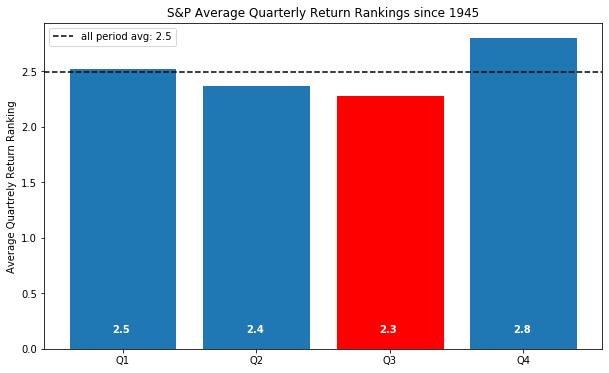

In [8]:
# for each year rank each quarter based on performance lowest=1 Highest=4
ranked = data_quarterly.groupby(data_quarterly.index.year).rank()

# average the ranks over all years for each month
final = ranked.groupby(ranked.index.quarter).mean()

# resize charts:
plt.rcParams['figure.figsize']=[10,6]

# plot a bar chart of the data:
bar_plot = plt.bar(x=final.index,height=final.returns)
bar_plot[2].set_color('r')
for i, v in enumerate(round(final.returns,1)):
    plt.text(i+0.92,0.15, str(v), color='white', fontweight='bold')
plt.axhline(final.returns.mean(),ls='--',color='k',label='all period avg: '+str(round(final.returns.mean(),1)))
plt.title("S&P Average Quarterly Return Rankings since 1945")
plt.ylabel("Average Quartrely Return Ranking")
plt.xticks([1,2,3,4], ['Q1', 'Q2', 'Q3', 'Q4'])
plt.legend()
plt.savefig('aqrr.png')
plt.show()

The beauty of simulation lies in its simplicity.

The following code is all we need to compute the p-value to answer the 1st question. We simply count how many values in our dataset using all 4000 AQRR (4 quarters x 1000 samples) are smaller than the observed Q3 value. We get a p-value of 3.5%, close to our somewhat arbitrary 5% cut off, but significant none the less.

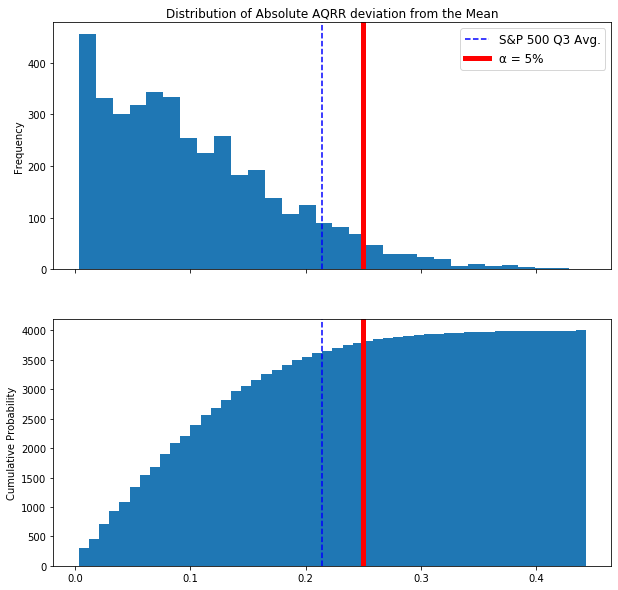

In [9]:
# create a list of all AQRR
all_quarters_aqrr = all_aqrr.values.flatten()

# calculate AQRR mean
all_quarters_aqrr_mu = all_quarters_aqrr.mean()

# calculate Absolute AQRR from the mean
abs_all_quarters_dev = abs(all_quarters_aqrr - all_quarters_aqrr_mu)

# set Q3 aqrr deviation to the variable
q3_aqrr = abs(final.returns.min() - all_quarters_aqrr_mu)




abs_all_quarters_95 = np.quantile(abs_all_quarters_dev,.95)

# resize charts:
plt.rcParams['figure.figsize']=[10,10]

fig, (ax1, ax2) = plt.subplots(2)

# Plot Probability Density Function of quarterly returns
ax1.hist(abs_all_quarters_dev, bins=30)
ax1.axvline(q3_aqrr,ls='--',color='b', label="S&P 500 Q3 Avg.")
ax1.axvline(abs_all_quarters_95,color='r',ls='-', lw=5, label="α = 5%")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution of Absolute AQRR deviation from the Mean")
# Plot Probability Density Function of quarterly returns
ax2.hist(abs_all_quarters_dev, bins=50, cumulative=True)
ax2.axvline(q3_aqrr,ls='--',color='b', label="S&P 500 Q3 Avg.")
ax2.axvline(abs_all_quarters_95,color='r',ls='-', lw=5, label="α = 5%")
ax2.set_ylabel("Cumulative Probability")

for ax in fig.get_axes():
    ax.label_outer()
    
ax1.legend(fontsize=12)
plt.show()

In [10]:
# Calculate p-value with our function:

p_value_calc(abs_all_quarters_dev, q3_aqrr) 

p-value = 0.101


To answer the 2nd question and to avoid multiplicity, instead of comparing our result to the distribution made with all 4'000 AQRR, we only consider the lowest value from each of the 1'000 AQRR samples. This gives a p-value of 14%, very much not significant!

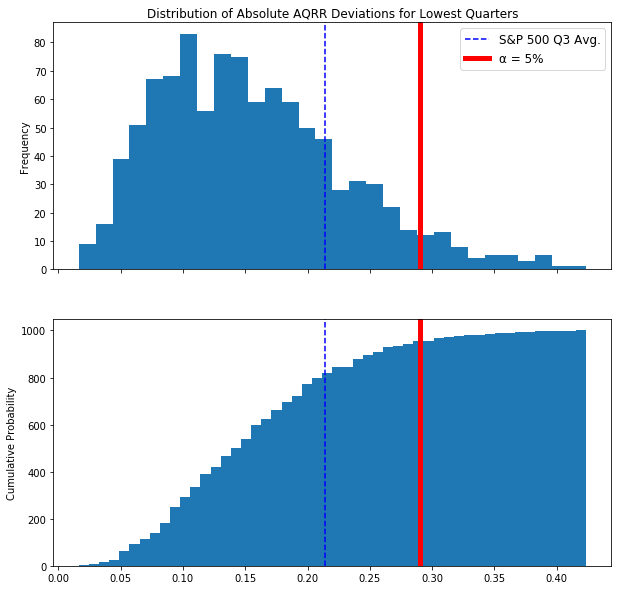

In [23]:
abs_lowest_dev = abs(lowest_only - all_quarters_aqrr_mu)

abs_all_quarters_95 = np.quantile(abs_lowest_dev,.95)

# resize charts:
plt.rcParams['figure.figsize']=[10,10]

fig, (ax1, ax2) = plt.subplots(2)

# Plot Probability Density Function of quarterly returns
ax1.hist(abs_lowest_dev, bins=30)
ax1.axvline(q3_aqrr,ls='--',color='b', label="S&P 500 Q3 Avg.")
ax1.axvline(abs_all_quarters_95,color='r',ls='-', lw=5, label="α = 5%")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution of Absolute AQRR Deviations for Lowest Quarters")
# Plot Probability Density Function of quarterly returns
ax2.hist(abs_lowest_dev, bins=50, cumulative=True)
ax2.axvline(q3_aqrr,ls='--',color='b', label="S&P 500 Q3 Avg.")
ax2.axvline(abs_all_quarters_95,color='r',ls='-', lw=5, label="α = 5%")
ax2.set_ylabel("Cumulative Probability")

for ax in fig.get_axes():
    ax.label_outer()
    
ax1.legend(fontsize=12)
plt.show()

In [12]:
# Define a counter and set it to 0
count=0

# Count the number of observations where the AQR deviation is greater or equal to S&P500 Q3 average
for i in abs_lowest_dev:
    if i >= q3_aqrr:
        count+=1

# Calculate p-value:
ans = count/len(abs_lowest_dev)        
print('p-value:', ans )

p-value: 0.2


In [13]:
p_value_calc(abs_lowest_dev, q3_aqrr)

p-value = 0.2


In [ ]:

    # calculate aqrr mean -for use in p-hacking section-
    #aqrr = aqrr.values.flatten()
    #aqrr_mu = np.mean(aqrr)
    
    # calculate and record aqrr most extreme vale -for use in p-hacking section-
    #aqrr_abs_dev = abs(aqrr - aqrr_mu)
    #most_extreme_idx = np.argmax(aqrr_abs_dev)
    #most_extreme_quarter = aqrr[most_extreme_idx]
    #most_extreme.append(most_extreme_quarter)

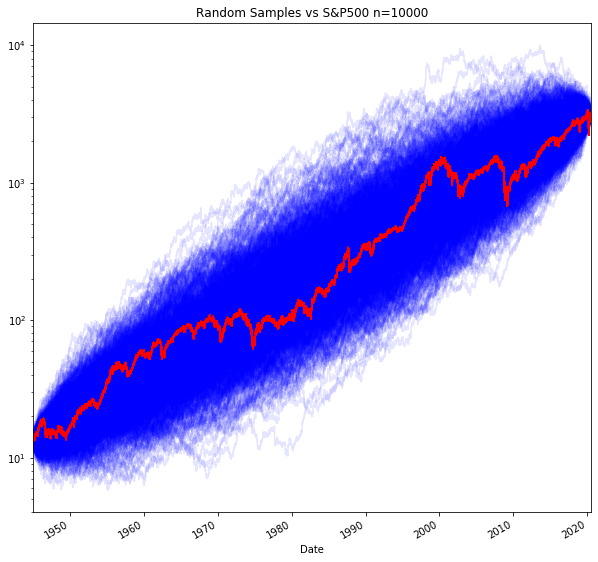

In [53]:
# set the random number seed so that results can be replicated
np.random.seed(1)

# set an empty container:
all_aqr = pd.DataFrame()
lowest_quarter = []

# empty containers to use later in our p-hacking section:
all_aqrr = pd.DataFrame()
lowest_only = []

# set the number of permutation samples we want to generate
n = 1000

# calculate actual daily_returns of the s&p 500
actual_rets = data_daily.Close.pct_change().dropna()

# set the number of observations
n_obs = actual_rets.count()

# generate our random samples using a for loop
for i in range(n):

    # create sample by permutation of actual returns
    sample_rets = np.random.permutation(actual_rets)

    # convert sample_rets to pd.series
    sample_rets = pd.Series(sample_rets, index=actual_rets.index)

    # select s&p 500 start price
    start = data_daily.Close.first('D')

    # add 1 to sample_rets and append to start
    sample_rets = sample_rets.add(1)
    sample_prices = start.append(sample_rets)

    # calculate the cumulative product
    sample_prices = sample_prices.cumprod()
    
    # resample sample_price to quarterly timeframe
    sample_prices_q = sample_prices.resample("Q").last()
    
    # calculate QoQ returns
    sample_rets_q = sample_prices_q.pct_change().dropna()

    # calculate the average quarterly returns
    aqr = sample_rets_q.groupby(sample_rets_q.index.quarter).mean() * 100
    
    # add our sample to the dataframe container
    all_aqr = pd.concat([all_aqr, aqr],axis=1)

    # also record the lowest AQR in each sample -for use in p-hacking section-
    min_quarter = min(aqr)
    lowest_quarter.append(min_quarter)
    
    # for each year rank each quarters based on returns lowest=1 Highest=4 -for use in p-hacking section-
    ranked_sample_q = sample_rets_q.groupby(sample_rets_q.index.year).rank()
    
    # calculate the average quarterly return ranks -for use in p-hacking section-
    aqrr = ranked_sample_q.groupby(ranked_sample_q.index.quarter).mean()
    
    # add our sample to the dataframe container -for use in p-hacking section-
    all_aqrr = pd.concat([all_aqrr, aqrr],axis=1)
    
    # also record the lowest AQRR in each sample -for use in p-hacking section-
    min_quarter = min(aqrr)
    lowest_only.append(min_quarter)
    
    # plot the generated samples vs s&p 500:
    sample_prices.plot(logy=True, color='blue', ls='-', alpha=0.1, title='Random Samples vs S&P500 n=10000')
    data_daily.Close.plot(color='r')